In [217]:
import tensorflow as tf
from tensorflow.keras import layers

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


import numpy as np
from numpy.random import seed, randint

In [218]:
seed(504)
tf.random.set_seed(504)

# Getting the data

In [219]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
X, y = mnist.data.reshape(-1, 28, 28, 1), tf.keras.utils.to_categorical(mnist.target)
X_train, y_train = X[:60_000], y[:60_000]
X_test, y_test = X[60_000:], y[60_000:]

c:\Users\oih\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


# Training the neural network

In [220]:
X.shape

(70000, 28, 28, 1)

In [233]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights=True)

cnn = tf.keras.models.Sequential([
    layers.Conv2D(16, 3, activation='relu', padding='same', input_shape=X_train[0].shape),
    layers.Dropout(.4),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.Dropout(.4),
    layers.MaxPooling2D(),
    layers.Conv2D(120, 3, activation='relu', padding='same'),
    layers.Dropout(.4),
    layers.Flatten(),
    layers.Dense(units=84, activation='relu'),
    layers.Dropout(.4),
    layers.Dense(units=10, activation='softmax')
])
cnn.summary()

Epoch 1/100
1500/1500 [==============================] - 27s 18ms/step - loss: 3.0131 - accuracy: 0.2393 - val_loss: 1.6902 - val_accuracy: 0.4265
Epoch 2/100
1500/1500 [==============================] - 27s 18ms/step - loss: 1.6403 - accuracy: 0.4360 - val_loss: 1.0254 - val_accuracy: 0.7872
Epoch 3/100
1500/1500 [==============================] - 27s 18ms/step - loss: 1.1428 - accuracy: 0.6508 - val_loss: 0.4337 - val_accuracy: 0.9327
Epoch 4/100
1500/1500 [==============================] - 27s 18ms/step - loss: 0.6780 - accuracy: 0.7997 - val_loss: 0.2399 - val_accuracy: 0.9571
Epoch 5/100
1500/1500 [==============================] - 27s 18ms/step - loss: 0.4433 - accuracy: 0.8694 - val_loss: 0.1543 - val_accuracy: 0.9658
Epoch 6/100
1500/1500 [==============================] - 27s 18ms/step - loss: 0.3107 - accuracy: 0.9114 - val_loss: 0.1088 - val_accuracy: 0.9760
Epoch 7/100
1500/1500 [==============================] - 27s 18ms/step - loss: 0.2389 - accuracy: 0.9322 - val_loss: 0

In [ ]:

cnn.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['accuracy'])

history = cnn.fit(X_train, y_train, 
                    epochs = 100, 
                    validation_split = 0.2,
                    callbacks=[es])

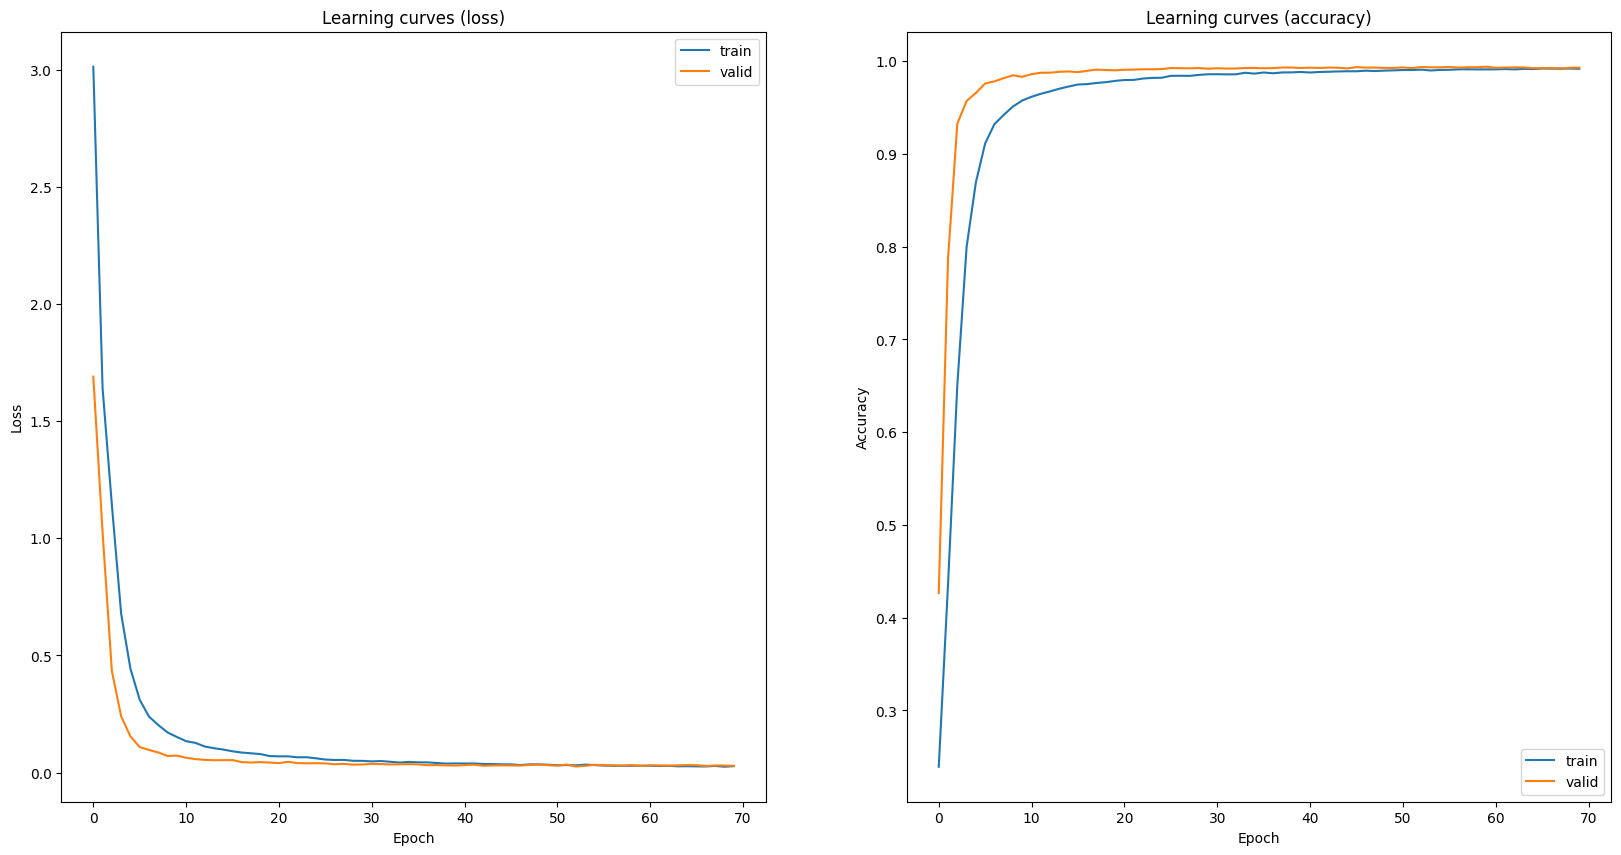

In [237]:
figure = plt.figure(figsize=(20, 10))
ax = figure.add_subplot(1, 2, 1, title='Learning curves (loss)')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.plot(history.history['loss'], label = 'train')
ax.plot(history.history['val_loss'], label = 'valid')
ax.legend()

ax = figure.add_subplot(1, 2, 2, title='Learning curves (accuracy)')
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.plot(history.history['accuracy'], label = 'train')
ax.plot(history.history['val_accuracy'], label = 'valid')
ax.legend()

plt.show()

In [241]:
train_eval = cnn.evaluate(X_train[:48000], y_train[:48000])
validation_eval = cnn.evaluate(X_train[48000:], y_train[48000:])
test_eval = cnn.evaluate(X_test, y_test)
print("On train data: Loss = {loss:.4f}, accuracy = {accuracy:.4f}".format(loss=train_eval[0], accuracy=train_eval[1]))
print("On validation data: Loss = {loss:.4f}, accuracy = {accuracy:.4f}".format(loss=validation_eval[0], accuracy=validation_eval[1]))
print("On test data: Loss = {loss:.4f}, accuracy = {accuracy:.4f}".format(loss=test_eval[0], accuracy=test_eval[1]))
print("Error on test data: {p:.2f}%".format(p = 100*(1-test_eval[1])))

313/313 [==============================] - 2s 5ms/step - loss: 0.0238 - accuracy: 0.9934
On train data: Loss = 0.0112, accuracy = 0.9991
On validation data: Loss = 0.0280, accuracy = 0.9941
On test data: Loss = 0.0238, accuracy = 0.9934
Error on test data: 0.66%


array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

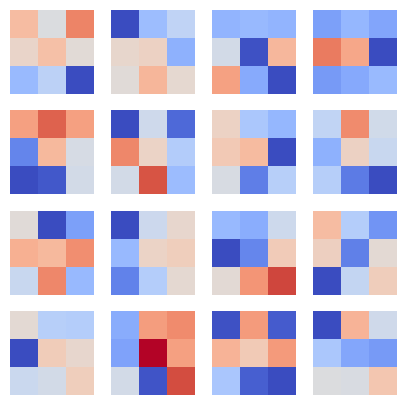

In [224]:
from plot_utils import grid_plot
from matplotlib.colors import CenteredNorm

kernel_weights = cnn.layers[0].weights[0]
kernel_shape = kernel_weights.shape[:2]
kernels = [kernel_weights[:, :, :, i].numpy().reshape(kernel_shape) for i in range(kernel_weights.shape[-1])]

def plot_kernel(ax, kernel, index):
    ax.axis('off')
    ax.imshow(kernel, cmap='coolwarm', norm=CenteredNorm())

grid_plot(kernels, 4, 4, plot_kernel, figsize=(5, 5))


# Consider misclassified digits

313/313 [==============================] - 1s 4ms/step


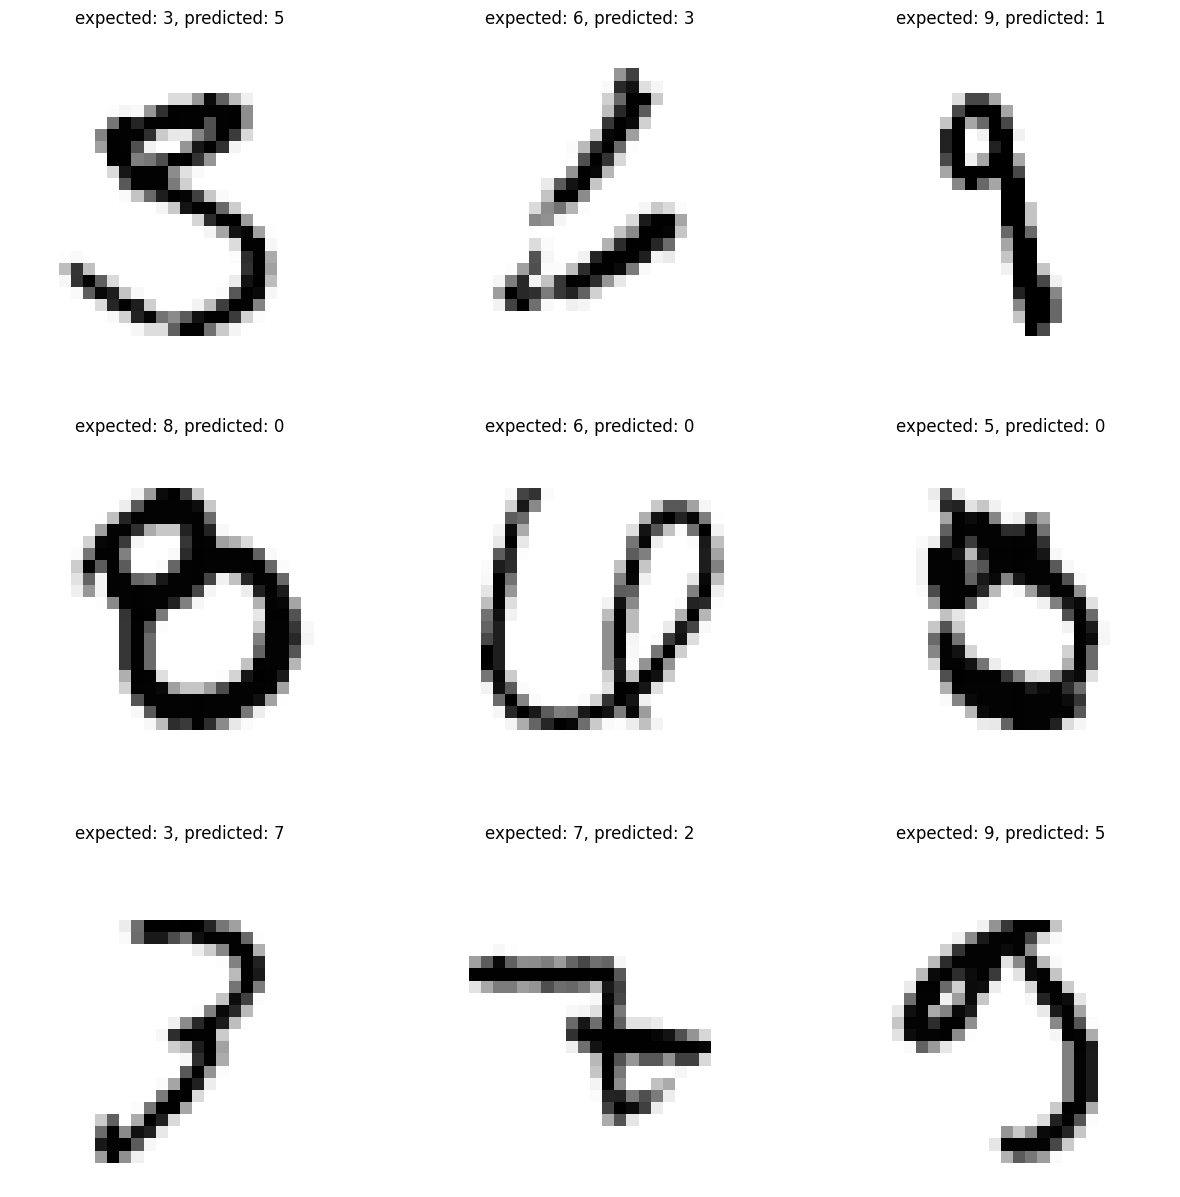

In [225]:
probabilities = np.array(cnn.predict(X_test))
predictions = np.argmax(probabilities, axis = 1) #what does the model predict
labels = np.argmax(y_test, axis = 1) #what are the actual labels
misclas_idxs = np.argwhere(predictions != labels).reshape(-1)

idxs = [misclas_idxs[randint(low = 0, high = len(misclas_idxs) - 1)] for i in range(9)] #choose 9 random indeces

figure = plt.figure(figsize=(15, 15))
for i in range(9):
    idx = idxs[i]
    ax = figure.add_subplot(3, 3, i + 1, title='expected: {}, predicted: {}'.format(labels[idx], predictions[idx]))
    ax.axis('off')
    ax.imshow(np.reshape(X_test[idx], (28, 28)), cmap='Greys')
